In [1]:
#  Survival Analysis for Modeling Singular Events Over Time

In [2]:
# intall packages
%pip install lifelines


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter



In [4]:
url = "https://peopleanalytics-regression-book.org/data/job_retention.csv"
job_retention = pd.read_csv(url)

job_retention.head()

,gender,field,level,sentiment,intention,left,month
0,M,Public/Government,High,3,8,1,1
1,F,Finance,Low,8,4,0,12
2,M,Education and Training,Medium,7,7,1,5
3,M,Finance,Low,8,4,0,12
4,M,Finance,High,7,6,1,1


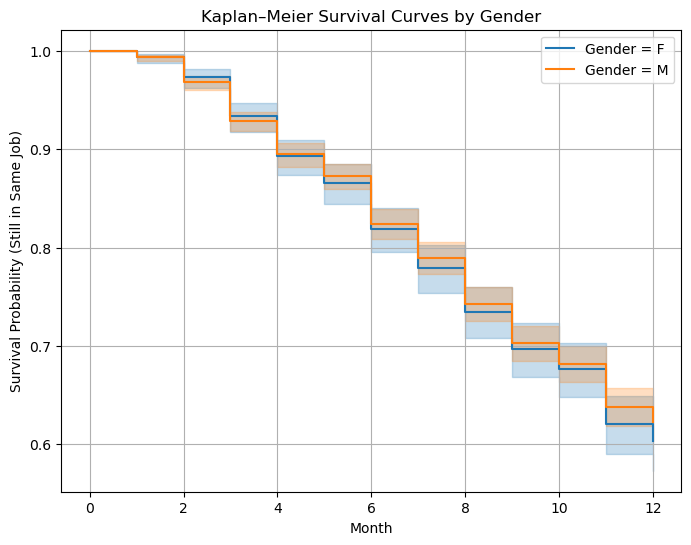

In [5]:
# Kaplan–Meier survival curves by gender

kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for gender, df_g in job_retention.groupby("gender"):
    kmf.fit(
        durations=df_g["month"],
        event_observed=df_g["left"],
        label=f"Gender = {gender}"
    )
    kmf.plot_survival_function()

plt.title("Kaplan–Meier Survival Curves by Gender")
plt.xlabel("Month")
plt.ylabel("Survival Probability (Still in Same Job)")
plt.grid(True)
plt.show()


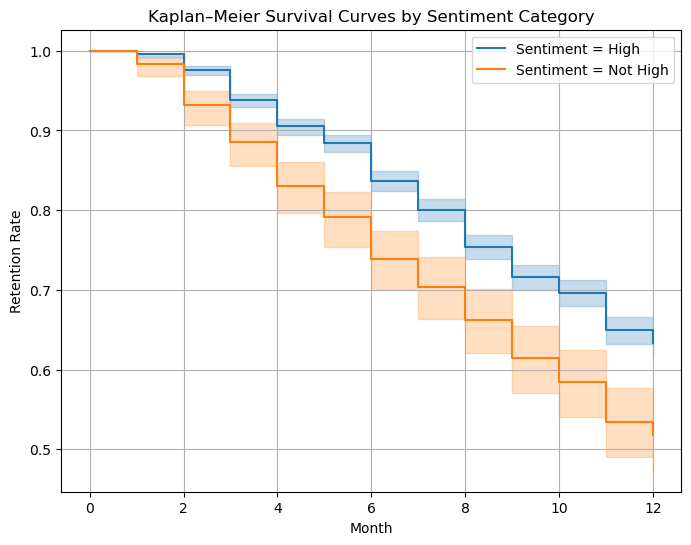

In [6]:
# Create sentiment categories
# Kaplan–Meier curves by sentiment category


job_retention["sentiment_category"] = job_retention["sentiment"].apply(
    lambda x: "High" if x >= 7 else "Not High"
)


kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

for cat, df_cat in job_retention.groupby("sentiment_category"):
    kmf.fit(
        durations=df_cat["month"],
        event_observed=df_cat["left"],
        label=f"Sentiment = {cat}"
    )
    kmf.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curves by Sentiment Category")
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.grid(True)
plt.show()


In [9]:
# Log-rank test (this is where the p-value comes from)

high = job_retention[job_retention["sentiment_category"] == "High"]
not_high = job_retention[job_retention["sentiment_category"] == "Not High"]

results = logrank_test(
    high["month"],
    not_high["month"],
    event_observed_A=high["left"],
    event_observed_B=not_high["left"]
)

results


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          32.63 <0.005     26.42

In [17]:
cox_df = job_retention.copy()

# ddta types
cox_df.dtypes


gender                object
field                 object
level                 object
sentiment              int64
intention              int64
left                   int64
month                  int64
sentiment_category    object
dtype: object

In [18]:
# Subset to the Cox variables only
cox_df = job_retention[
    ["month", "left", "gender", "field", "level", "sentiment"]
].copy()


In [19]:
# we must manually one-hot encode categoricals
cox_df = pd.get_dummies(
    cox_df,
    columns=["gender", "field", "level"],
    drop_first=True
)




In [21]:
# Fit the Cox proportional hazards model
cph = CoxPHFitter()

cph.fit(
    cox_df,
    duration_col="month",
    event_col="left"
)


<lifelines.CoxPHFitter: fitted with 3770 total observations, 2416 right-censored observations>

In [22]:
# View the model summary
cph.summary


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sentiment,-0.117562,0.889085,0.013971,-0.144945,-0.090179,0.865070,0.913767,0.0,-8.414645,3.940873e-17,54.494262
gender_M,-0.045485,0.955534,0.058858,-0.160844,0.069874,0.851425,1.072373,0.0,-0.772791,4.396460e-01,1.185586
field_Finance,0.223341,1.250247,0.066810,0.092396,0.354286,1.096799,1.425163,0.0,3.342929,8.289904e-04,10.236357
field_Health,0.278305,1.320889,0.128904,0.025658,0.530951,1.025990,1.700550,0.0,2.159011,3.084934e-02,5.018616
field_Law,0.105322,1.111069,0.145153,-0.179172,0.389816,0.835962,1.476709,0.0,0.725597,4.680857e-01,1.095155
field_Public/Government,0.114992,1.121864,0.088987,-0.059419,0.289403,0.942312,1.335629,0.0,1.292232,1.962768e-01,2.349038
field_Sales/Marketing,0.087764,1.091731,0.102114,-0.112375,0.287904,0.893709,1.333629,0.0,0.859472,3.900800e-01,1.358158
level_Low,0.148131,1.159665,0.090004,-0.028274,0.324536,0.972122,1.383388,0.0,1.645824,9.979995e-02,3.324817
level_Medium,0.176664,1.193231,0.102030,-0.023310,0.376639,0.976960,1.457378,0.0,1.731502,8.336229e-02,3.584461



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3770 total observations, 2416 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic    p  -log2(p)
field_Finance           km              1.20 0.27      1.88
                        rank            1.09 0.30      1.76
field_Health            km              4.27 0.04      4.69
                        rank            4.10 0.04      4.54
field_Law               km              1.14 0.29      1.81
                        rank            0.85 0.36      1.49
field_Public/Government km              1.92 0.17      2.59
                        rank            1.87 0.17      2.54
field_Sales/Marketing   km              2.00 0.16      2.67
                        rank            2.22 0.14      2.88
gender_M                km              0.41 0.52      0.94
                        rank            0.39 0.53      0.91
level_Low               km              1.53 0.22      2.21
                        rank            1.52 0.22      2.20
level_Medium            km              0.09 0.77      0.38
                        rank            0.13 0.72      0.47
sentiment               km              2.78 0.10      3.39
                        rank            2.32 0.13      2.97



1. Variable 'field_Health' failed the non-proportional test: p-value is 0.0387.

   Advice: with so few unique values (only 2), you can include `strata=['field_Health', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.htm

[[<Axes: xlabel='rank-transformed time\n(p=0.1275)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0957)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5340)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5219)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2958)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2726)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0430)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0387)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3568)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2851)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1715)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1655)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1362)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1576)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2180)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2159)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7235)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7670)'>]]

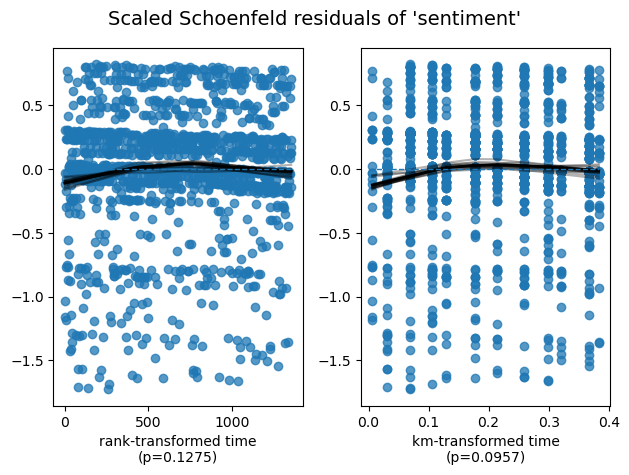

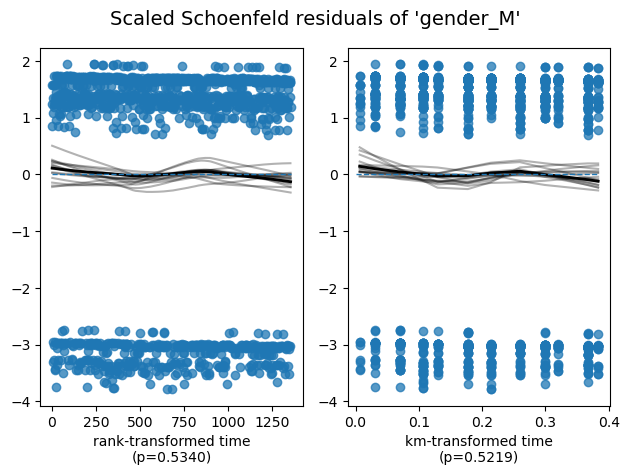

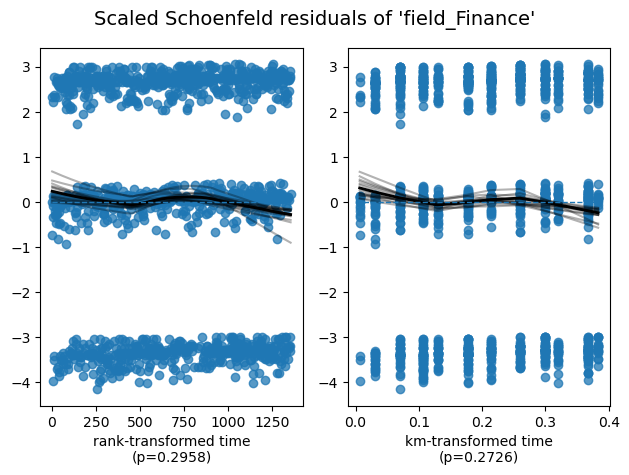

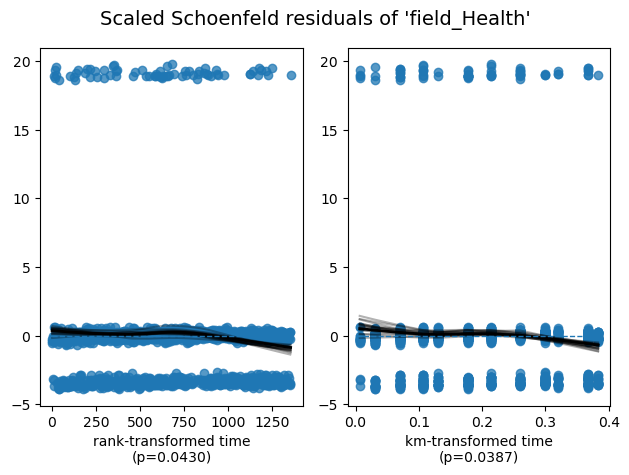

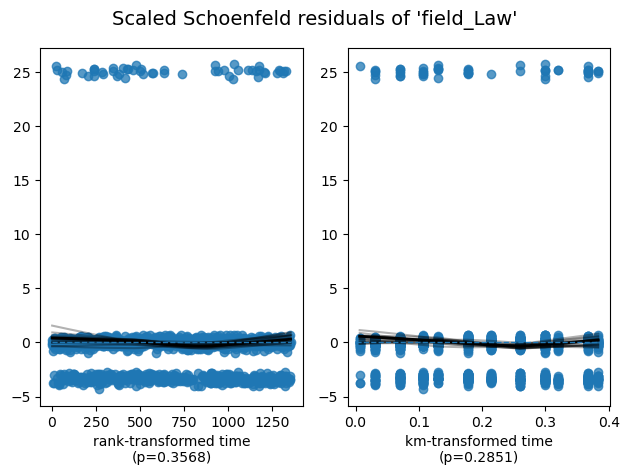

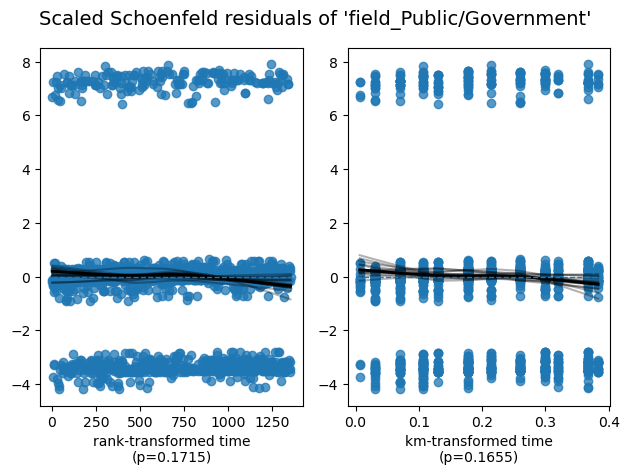

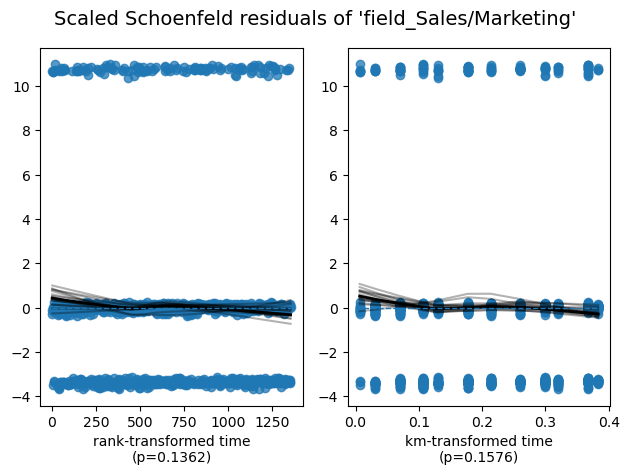

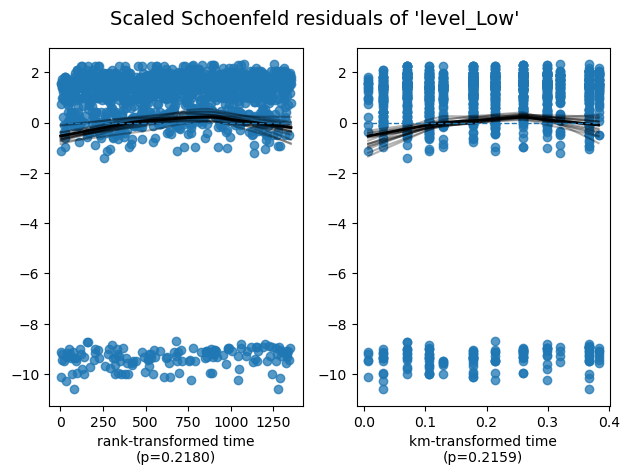

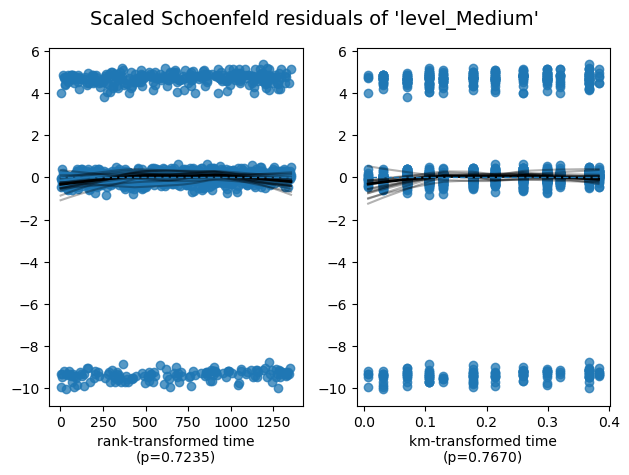

In [23]:
# Check the proportional hazards assumption
cph.check_assumptions(
    cox_df,
    p_value_threshold=0.05,
    show_plots=True
)
